In [1]:
from scipy.spatial.transform import Rotation

from dust3r.inference import inference, load_model
from dust3r.image_pairs import make_pairs
from dust3r.utils.image import load_images, rgb
from dust3r.utils.device import to_numpy
from dust3r.viz import add_scene_cam, CAM_COLORS, OPENGL, pts3d_to_trimesh, cat_meshes
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode
import cv2
# cv2.caliberatehandeye
import matplotlib.pyplot as plt
from dust3r.utils.geometry import find_reciprocal_matches, xy_grid

ModuleNotFoundError: No module named 'dust3r.inference'

In [2]:
import torch
import numpy as np
import os

import torch.nn as nn
import torch.optim as optim

import plotly.graph_objects as go

In [60]:
def get_file_paths(folder_path):
    file_paths = []  # List to store file paths
    # Walk through all files and directories in the specified folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)  # Create full file path
            file_paths.append(file_path)  # Add file path to list
    # Sort the list based on filenames
    file_paths.sort(key=lambda path: os.path.basename(path))
    return file_paths

def rpy_to_rot_matrix(roll, pitch, yaw):
    # Calculate rotation matrix components
    cosr = torch.cos(roll)
    sinr = torch.sin(roll)
    cosp = torch.cos(pitch)
    sinp = torch.sin(pitch)
    cosy = torch.cos(yaw)
    siny = torch.sin(yaw)

    # Row 1
    r11 = cosy * cosp
    r12 = cosy * sinp * sinr - siny * cosr
    r13 = cosy * sinp * cosr + siny * sinr

    # Row 2
    r21 = siny * cosp
    r22 = siny * sinp * sinr + cosy * cosr
    r23 = siny * sinp * cosr - cosy * sinr

    # Row 3
    r31 = -sinp
    r32 = cosp * sinr
    r33 = cosp * cosr

    return torch.stack((r11, r12, r13, r21, r22, r23, r31, r32, r33), dim=-1).view(-1, 3, 3)

def pose_to_transform(pose_batch):
    # Unpack the pose components
    roll = pose_batch[:, 0]
    pitch = pose_batch[:, 1]
    yaw = pose_batch[:, 2]
    t = pose_batch[:, 3:6]

    # Convert RPY to rotation matrices
    rotation_matrices = rpy_to_rot_matrix(roll, pitch, yaw)

    # Create the transformation matrices
    transform_matrices = torch.zeros((pose_batch.shape[0], 4, 4), dtype=torch.float)
    transform_matrices[:, :3, :3] = rotation_matrices
    transform_matrices[:, :3, 3] = t
    transform_matrices[:, 3, 3] = 1.0

    return transform_matrices

def residual_error(R, A, B):
    """
    Compute the residual error for the rotation matrix R.
    
    Parameters:
    R : torch.Tensor
        The estimated rotation matrix of shape (3, 3).
    A, B : torch.Tensor
        3D rotation tensors of shape (N, 3, 3) representing sequences of 
        transformations A and B respectively.
    
    Returns:
    error : float
        The average residual error.
    """
    N = A.shape[0]
    errors = []
    for i in range(N):
        RA = R.mm(A[i])
        BR = B[i].mm(R)
        error = (RA - BR).norm()
        errors.append(error.item())
    return sum(errors) / N

In [4]:
device="cuda"
model_path = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
model = load_model(model_path, device)

... loading model from checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='dpt', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>


In [5]:
folder_path = 'imgs'
file_paths = get_file_paths(folder_path)#[:4]

In [101]:
#file_paths[:4]

In [6]:
images = load_images(file_paths, size=512)

>> Loading a list of 6 images
 - adding imgs/sixangs_1feature_0.jpg with resolution 640x480 --> 512x384
 - adding imgs/sixangs_1feature_1.jpg with resolution 640x480 --> 512x384
 - adding imgs/sixangs_1feature_2.jpg with resolution 640x480 --> 512x384
 - adding imgs/sixangs_1feature_3.jpg with resolution 640x480 --> 512x384
 - adding imgs/sixangs_1feature_4.jpg with resolution 640x480 --> 512x384
 - adding imgs/sixangs_1feature_5.jpg with resolution 640x480 --> 512x384
 (Found 6 images)


In [10]:
schedule = 'cosine'
lr = 0.01
niter = 3000
batch_size = 3

In [8]:
pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
output = inference(pairs, model, device, batch_size=batch_size)

>> Inference with model on 30 image pairs


100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.54it/s]


In [ ]:
scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)

In [ ]:
loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

 init edge (1*,3*) score=10.76913833618164
 init edge (1,2*) score=10.731603622436523
 init edge (1,0*) score=8.356725692749023
 init edge (2,4*) score=7.178244113922119
 init edge (3,5*) score=5.944360733032227
 init loss = 0.0045401062816381454


 86%|██████ | 2572/3000 [01:42<00:17, 25.03it/s, lr=0.000494809 loss=0.00155629]

In [12]:
imgs = scene.imgs
focals = scene.get_focals()
poses = scene.get_im_poses()
pts3d = scene.get_pts3d()
confidence_masks = scene.get_masks()

In [13]:
focals

tensor([[559.4595],
        [590.0755],
        [582.5375],
        [588.3459],
        [581.2816],
        [636.7211]], device='cuda:0', grad_fn=<ExpBackward0>)

In [14]:
pts3d[1].reshape((-1,3))

tensor([[-0.2528, -0.1984,  0.5866],
        [-0.2525, -0.1990,  0.5886],
        [-0.2527, -0.1999,  0.5915],
        ...,
        [ 0.0529,  0.0403,  0.1250],
        [ 0.0541,  0.0411,  0.1273],
        [ 0.0560,  0.0424,  0.1313]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

In [16]:
pts_list=[]
for i in range(len(imgs)):
    sel_pts=pts3d[i][confidence_masks[i]]
    pts_list.append(sel_pts)

In [17]:
pts_tor=torch.cat(pts_list)

In [18]:
def extract_positions_directions(transform_matrices):
    positions = transform_matrices[:, :3, 3]
    forward_directions = transform_matrices[:, :3, 2]  # Negate if your camera looks along the -Z axis
    return positions, forward_directions

In [20]:
positions, directions = extract_positions_directions(poses)

In [21]:
positions=positions.detach().cpu()
directions=directions.detach().cpu()

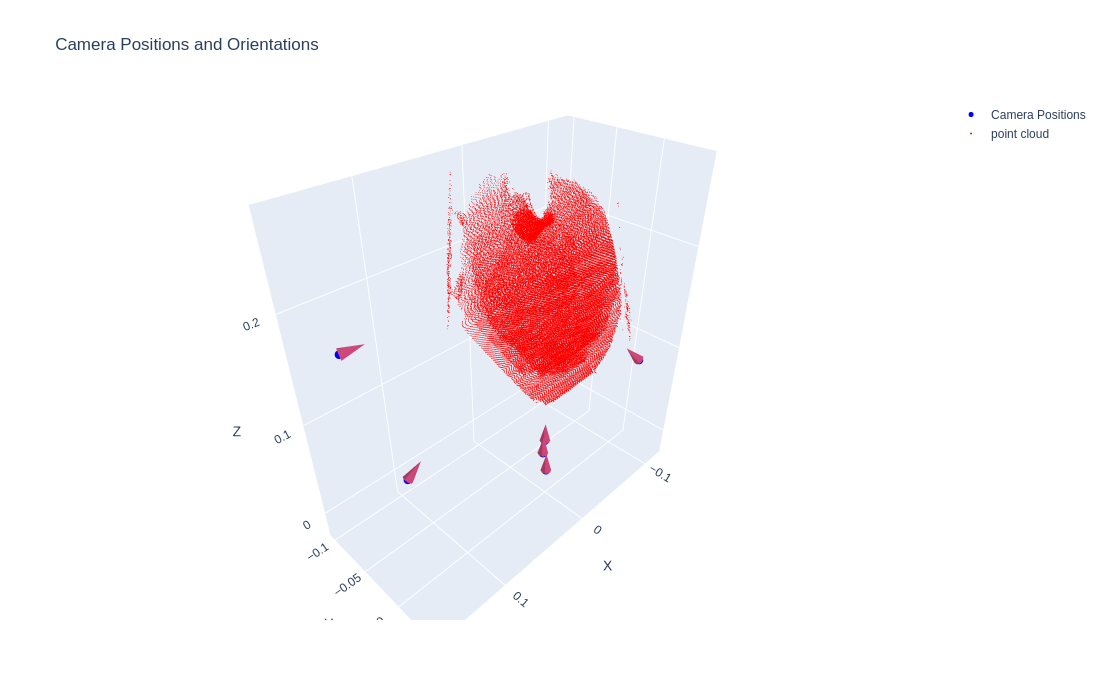

In [22]:
fig = go.Figure()

# Camera positions
fig.add_trace(go.Scatter3d(x=positions[:, 0], y=positions[:, 1], z=positions[:, 2],
                           mode='markers', marker=dict(size=5, color='blue'), name='Camera Positions'))

fig.add_trace(go.Scatter3d(x=pts_tor[::10, 0].detach().cpu(),  # X coordinates
    y=pts_tor[::10, 1].detach().cpu(),  # Y coordinates
    z=pts_tor[::10, 2].detach().cpu(),  # Z coordinates
                           mode='markers', marker=dict(size=0.5, color='red'),name="point cloud"))

# Directions
for position, direction in zip(positions, directions):
    fig.add_trace(go.Cone(x=[position[0]], y=[position[1]], z=[position[2]],
                          u=[direction[0]], v=[direction[1]], w=[direction[2]],
                          anchor="tail", showscale=False, sizeref=0.02))

fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title="Camera Positions and Orientations")

fig.update_layout(width=1000, height=700)
fig.show()

In [29]:
scale_factor=(0.05)/(0.5*(torch.norm(positions[1]-positions[2])+torch.norm(positions[2]-positions[3])))

In [30]:
torch.norm(positions[1]-positions[2])

tensor(0.0165)

In [31]:
torch.norm(positions[3]-positions[2])

tensor(0.0119)

In [36]:
eef_poses = [
    [3.008, -0.668, 0.549, -0.16574, -0.268, 0.5065], # right back
    [-3.008, -0.5914, -0.633, -0.111, 0.2634, 0.485], # left back
    [-3.008, -0.5914, -0.633, -0.061, 0.2634, 0.485], # left back x + 5cm
    [-3.008, -0.5914, -0.633, -0.011, 0.2634, 0.485], # left back x + 10cm
    [-1.8205, 0.179, -0.2795, 0.256, -0.5694, 0.157],
    [1.721, 0.179, 0.2195, 0.326, 0.5645, 0.1535]
]
eef_poses_6d=torch.tensor(eef_poses)

In [37]:
eef_mats=pose_to_transform(eef_poses_6d)[:4] # only use top 4 as the end-effector is now not consistent

In [38]:
poses_scaled=poses[:4].clone()
poses_scaled[:,:3,3]=poses_scaled[:,:3,3]*scale_factor

In [39]:
poses_scaled

tensor([[[ 4.8394e-01,  6.0972e-01, -6.2773e-01,  4.2442e-01],
         [-6.5926e-01,  7.2574e-01,  1.9668e-01, -1.7944e-01],
         [ 5.7549e-01,  3.1865e-01,  7.5317e-01,  1.4288e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.9991e-01, -1.3455e-02, -3.4082e-04,  0.0000e+00],
         [ 1.3453e-02,  9.9989e-01, -5.9936e-03,  0.0000e+00],
         [ 4.2143e-04,  5.9885e-03,  9.9998e-01,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.9973e-01, -2.3159e-02,  1.0066e-03, -2.1335e-02],
         [ 2.3138e-02,  9.9958e-01,  1.7252e-02, -3.7072e-02],
         [-1.4057e-03, -1.7224e-02,  9.9985e-01,  3.9447e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.9985e-01, -1.6952e-02,  2.5932e-03, -4.6374e-02],
         [ 1.6947e-02,  9.9985e-01,  1.8933e-03, -5.2869e-02],
         [-2.6249e-03, -1.8491e-03,  9.9999e-01,  6.8976e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, 

In [98]:
# world-space coordinates to camera pose
poses_scaled_np=np.array(torch.linalg.inv(poses_scaled).cpu().detach())

In [99]:
# robot base to manipulator end-effector pose
eef_mats_np=np.array(eef_mats.cpu().detach())

In [100]:
eef_mats_np[:,:3,3]

array([[-0.16574, -0.268  ,  0.5065 ],
       [-0.111  ,  0.2634 ,  0.485  ],
       [-0.061  ,  0.2634 ,  0.485  ],
       [-0.011  ,  0.2634 ,  0.485  ]], dtype=float32)

In [101]:
poses_scaled_np[:,:3,3]

array([[-0.4059118 , -0.17407796,  0.19409871],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.02224237,  0.03724222, -0.03878021],
       [ 0.04744378,  0.05220281, -0.06875501]], dtype=float32)

In [102]:
eef_mats_np[:,:3,3]

array([[-0.16574, -0.268  ,  0.5065 ],
       [-0.111  ,  0.2634 ,  0.485  ],
       [-0.061  ,  0.2634 ,  0.485  ],
       [-0.011  ,  0.2634 ,  0.485  ]], dtype=float32)

In [103]:
import cv2

In [104]:
#https://docs.opencv.org/4.5.4/d9/d0c/group__calib3d.html#gaebfc1c9f7434196a374c382abf43439b

In [105]:
rot

array([[ 0.38124964,  0.52260347, -0.76258398],
       [-0.92370231,  0.1816844 , -0.33729042],
       [-0.03771953,  0.83299243,  0.55199714]])

In [106]:
rot,tr=cv2.calibrateHandEye(eef_mats_np[:,:3,:3],eef_mats_np[:,:3,3],
        poses_scaled_np[:,:3,:3],poses_scaled_np[:,:3,3],method=cv2.CALIB_HAND_EYE_DANIILIDIS)

In [107]:
tr

array([[ 1.43729574],
       [ 0.19797897],
       [-2.90456832]])

In [108]:
residual_error(torch.tensor(rot).float(),
               torch.tensor(eef_mats_np[:,:3,:3]).float(),
               torch.tensor(poses_scaled_np[:,:3,:3]).float()
               )

2.754499852657318